In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
!pip install haversine
from haversine import haversine
import warnings; warnings.simplefilter('ignore')



from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1ndBO1KKbCgiW4XkBdlX5V1dTqswUQtcj/view?usp=sharing'

 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('NYC Taxi Data.csv') 
 
df = pd.read_csv('NYC Taxi Data.csv')

In [ ]:
data=df
data.head()


In [ ]:
data.shape 

In [ ]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
data.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
data['month'] = data.pickup_datetime.dt.month
data.head(3)
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour


In [ ]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)
data['speed'] = (data.distance/(data.trip_duration/3600))
data.dtypes.reset_index()    

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [ ]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


# **Trips per Weekday**

In [ ]:
sns.countplot(x = 'weekday', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              data=data);
plt.title("Trip frequency per the day of the week");
plt.xlabel("Day of the Week");
plt.ylabel("Frequency");

# **Trip Duration per Hour**

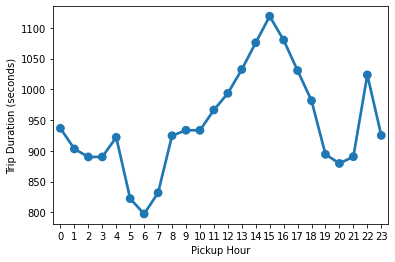

In [ ]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

# **Trip duration per weekday**

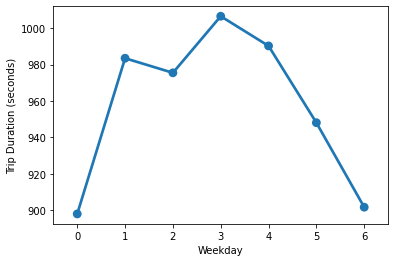

In [ ]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

# **Distance Per Hour**

In [ ]:
distance_per_hour = data.groupby('pickup_hour').distance.mean()
sns.pointplot(distance_per_hour.index, distance_per_hour.values,color = 'green',palette=sns.color_palette(["#000000", "#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7"]))
plt.ylabel('Distance (km)')
plt.show()

# **Distance Per Weekday**

In [ ]:
distance_per_weekday = data.groupby('pickup_day').distance.mean()
sns.pointplot(distance_per_weekday.index, distance_per_weekday.values,order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
,color = 'brown')
plt.ylabel('Distance (km)')
plt.show()

# **Which Hour Has More Rush?**




In [ ]:
#Classsifying hours into morning , afternoon and evening 
data['pickup_time_of_the_day'] = data.pickup_hour.apply(lambda y: (y % 24 + 4)//4).replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Afternoon',
                      5: 'Evening',
                      6: 'Night'})

In [1]:
sns.countplot(x = 'pickup_time_of_the_day', order=['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night'],
              data=data);
plt.title("Trip frequency per the time of the day");
plt.xlabel("Time of the Day");
plt.ylabel("Frequency");

NameError: ignored

# ***FEATURE SELECTION***

In [ ]:
list(zip( range(0,len(data.columns)),data.columns))
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1458644 rows of 1's as the first column in the X array


In [ ]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [ ]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("====================================================================\n")
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()    

Probability values of each feature 

[1.10746936e-002 0.00000000e+000 0.00000000e+000 9.68103956e-001
 3.90406640e-108 7.63656654e-001 9.62608418e-001 2.61814546e-001
 1.21237518e-002 1.05183138e-003 7.14565444e-007 2.45758471e-005
 9.83647608e-008 2.26966030e-007 3.76503049e-007 2.68811164e-001
 9.85903377e-001 6.81711561e-001 7.70603578e-001 6.28604631e-001
 3.52248313e-003 5.01291190e-002 5.57667656e-002 6.91375063e-001
 3.74768701e-001 5.46116266e-001 3.29409236e-001 6.87999006e-002
 2.05262772e-002 5.42883549e-003 3.84379671e-005 7.33794379e-003
 4.71587624e-002 1.08410327e-001 5.38780849e-001 2.00133738e-001
 1.62760871e-001 1.20566049e-002 1.79415669e-001 1.00649017e-001
 1.03696763e-001 1.12146123e-001 1.17022752e-001 1.05590029e-001
 1.06330173e-001 5.20846372e-001]


Feature at index 16 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[1.10641307e-002 0.00000000e+000 0.00000000e+000 9.68093143e-001
 3.89440588e-108 7.63618842e-001 9.62580641

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1005.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:44:32   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458621   BIC:                         2.910e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.2426     12.041     53.338      0.000     618.643     665.843
x1           164.8220      1.148    143.630      0.000     162.573     167.071
x2           -28.9725      0.332    -87.332      0.000     -29.623     -28.322
x3           203.8606      8.631     23.621      0.000     186.945     220.776
x4            32.1097     11.697      2.745      0.006       9.184      55.035
x5            44.0644     11.974      3.680      0.000      20.596      67.533
x6            73.9658     14.315      5.167      0.000      45.909     102.022
x7            60.7654     14.167      4.289      0.000      32.998      88.533
x8            78.0896     13.997      5.579      0.000      50.655     105.524
x9            75.0618     13.885      5.406      0.000      47.848     102.276
x10           74.1684     13.917      5.329      0.000      46.892     101.445
x11         -168.7635     43.032     -3.922      0.000    -253.105     -84.422
x12         -101.6475     29.312     -3.468      0.001    -159.099     -44.196
x13          -91.0567     23.014     -3.957      0.000    -136.163     -45.950
x14           40.8467     20.470      1.995      0.046       0.725      80.968
x15           53.9859     20.123      2.683      0.007      14.546      93.426
x16           94.3189     20.434      4.616      0.000      54.270     134.368
x17           53.6104     21.478      2.496      0.013      11.515      95.706
x18          -46.0098     18.444     -2.495      0.013     -82.159      -9.861
x19          -65.3320     19.044     -3.431      0.001    -102.658     -28.006
x20          -68.4386     19.038     -3.595      0.000    -105.753     -31.124
x21           45.2142     19.424      2.328      0.020       7.144      83.285
x22          -67.7949     20.730     -3.270      0.001    -108.425     -27.165
================================================================================
Omnibus:                  8330196.946   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2368102451061102.500
Skew:                         350.196   Prob(JB):                           0.00
Kurtosis:                  197394.513   Cond. No.                           213.
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ***FEATURE Extraction***

In [ ]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

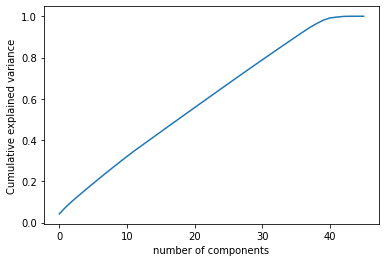

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.21),
 (2, 7.68),
 (3, 10.65),
 (4, 13.450000000000001),
 (5, 16.220000000000002),
 (6, 18.94),
 (7, 21.630000000000003),
 (8, 24.290000000000003),
 (9, 26.900000000000002),
 (10, 29.500000000000004),
 (11, 32.02),
 (12, 34.53),
 (13, 36.9),
 (14, 39.269999999999996),
 (15, 41.629999999999995),
 (16, 43.989999999999995),
 (17, 46.339999999999996),
 (18, 48.69),
 (19, 51.03),
 (20, 53.370000000000005),
 (21, 55.71000000000001),
 (22, 58.05000000000001),
 (23, 60.38000000000001),
 (24, 62.71000000000001),
 (25, 65.04),
 (26, 67.36),
 (27, 69.67999999999999),
 (28, 71.99),
 (29, 74.28999999999999),
 (30, 76.57),
 (31, 78.85),
 (32, 81.11999999999999),
 (33, 83.38),
 (34, 85.64),
 (35, 87.89),
 (36, 90.11),
 (37, 92.32),
 (38, 94.47),
 (39, 96.37),
 (40, 98.04),
 (41, 99.17),
 (42, 99.59),
 (43, 99.92),
 (44, 100.0),
 (45, 100.0)]

In [ ]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

# **HEATMAP**

**On FEATURE Selection Data**

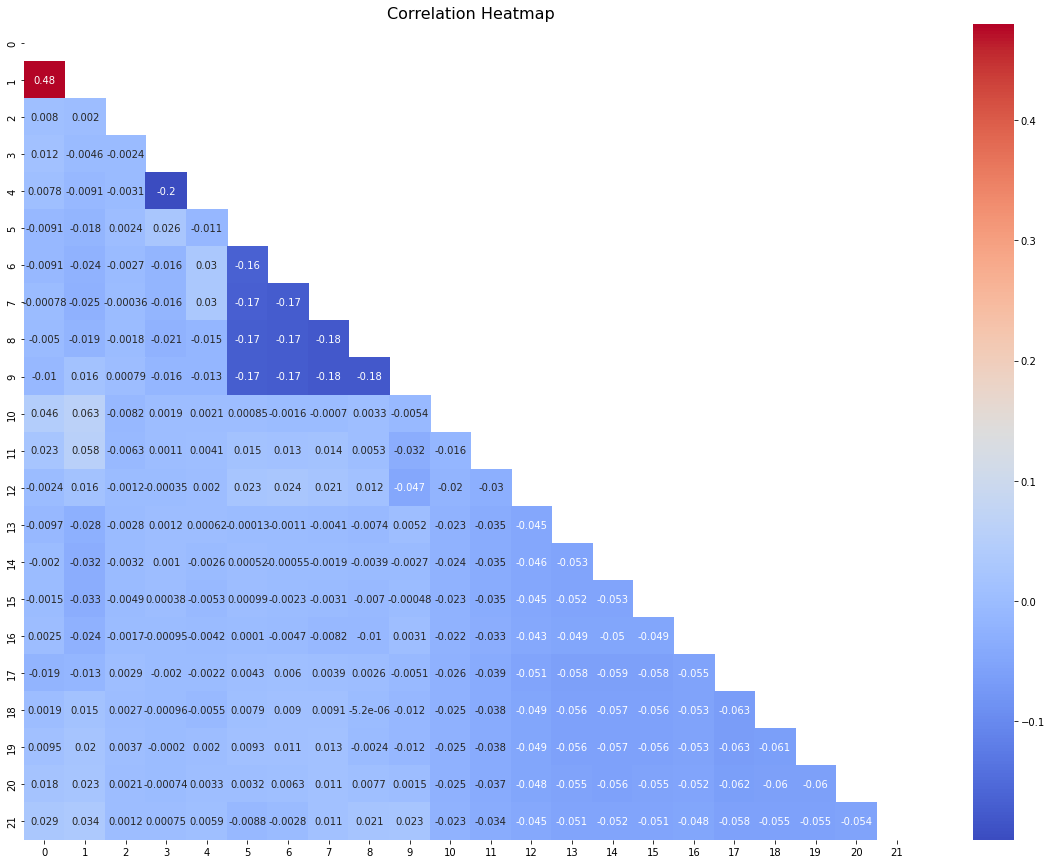

In [ ]:
plt.figure(figsize=(20,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap((corr),mask=mask, annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

**On FEATURE Extraction Data**

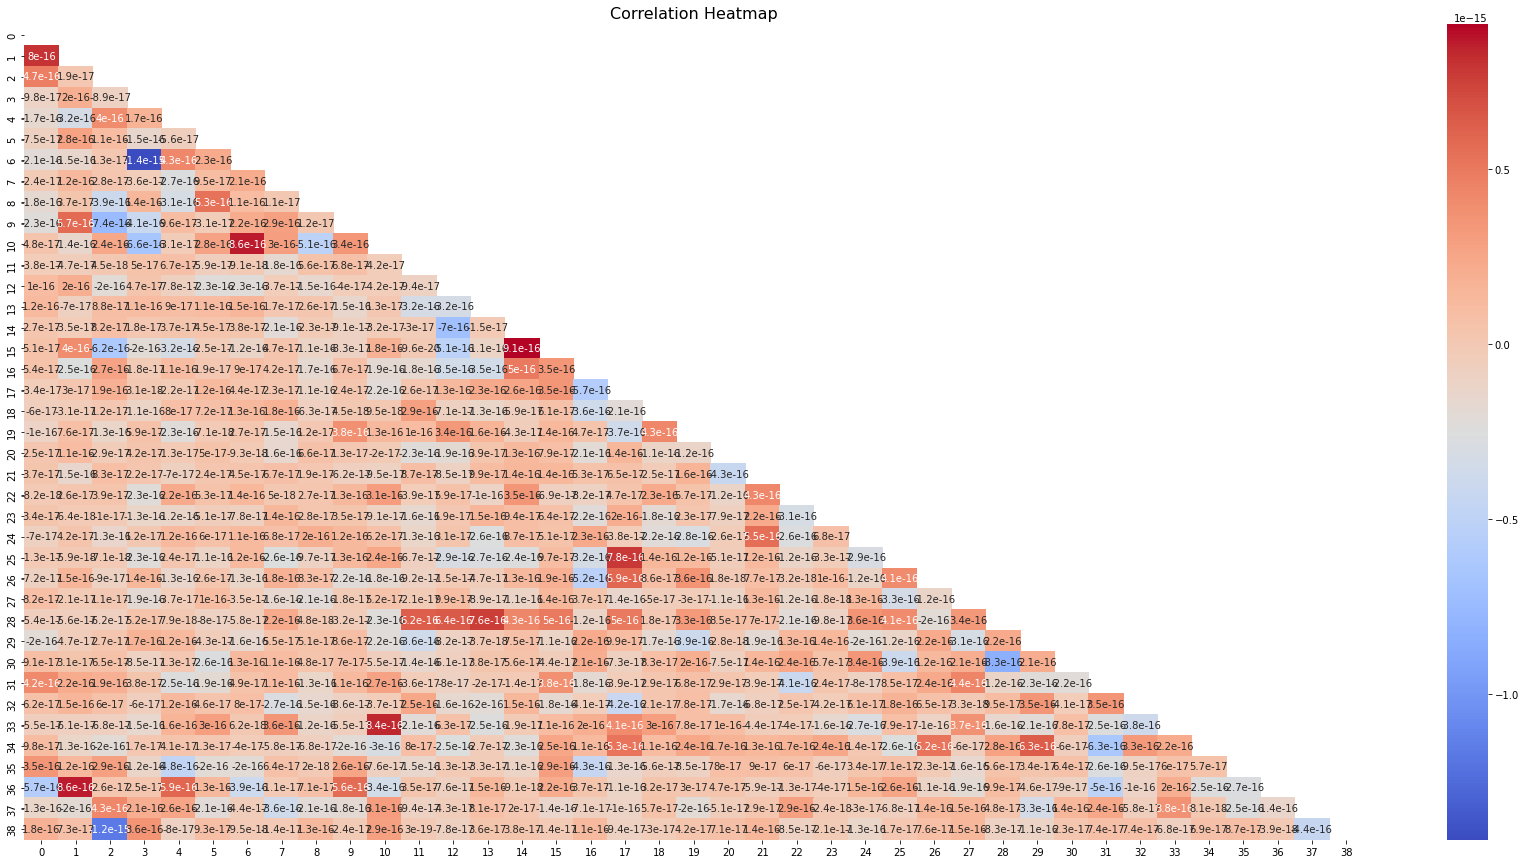

In [ ]:
plt.figure(figsize=(30,15))
corr = pd.DataFrame(X_train_pca[:,1:]).corr()
corr.index = pd.DataFrame(X_train_pca[:,1:]).columns
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap((corr),mask=mask, annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

# **LASSO** **REGRESSION**

In [ ]:
# Create an instance of Lasso Regression implementation
from sklearn.linear_model import Lasso
lasso1 = Lasso(alpha=0.1, max_iter=3000)
lasso2 = Lasso(alpha=0.1, max_iter=3000)
lasso3 = Lasso(alpha=0.1, max_iter=3000)

In [ ]:
# Fit the Lasso model on raw data
lasso1.fit(X_train, y_train)
# Create the model score
print(lasso1.score(X_test, y_test), lasso1.score(X_train, y_train))

0.018693199085457524 0.014047715261447324


In [ ]:
# Fit the Lasso model on Feature Selection data
lasso2.fit(X_train_fs,y_train_fs)
# Create the model score
print(lasso2.score(X_test_fs,y_test_fs), lasso2.score(X_train_fs,y_train_fs))

0.018719065430941373 0.014028956138338766


In [ ]:
# Fit the Lasso model on Feature Extraction data
lasso3.fit(X_train_pca,y_train_pca)
# Create the model score
print(lasso3.score(X_test_pca,y_test_pca), lasso3.score(X_train_pca,y_train_pca))

0.004802109469983384 0.0035125717286725866


# **Model Prediction**

# Feature Selection Based

Train Data

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_lasso_fs=lasso2.predict(X_train_fs)
y_pred_test_lasso_fs=lasso2.predict(X_test_fs)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train), (y_pred_train_lasso_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train, y_pred_train_lasso_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train, y_pred_train_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train, y_pred_train_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 27719324.66652857
RMSE : 5264.914497551557
MAE : 383.75259561250914
R2 : 0.014028956138338766
Adjusted R2 : 0.013873462593939068


Test Data

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_lasso_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_lasso_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 24236102.964786097
RMSE : 4923.017668542953
MAE : 385.85788817415374
R2 : 0.014028956138338766
Adjusted R2 : 0.018564311544893686


# Feature Extraction Based

Train Data

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_lasso_pca=lasso3.predict(X_train_pca)
y_pred_test_lasso_pca=lasso3.predict(X_test_pca)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train), (y_pred_train_lasso_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train, y_pred_train_lasso_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train, y_pred_train_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train, y_pred_train_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 28014979.468547743
RMSE : 5292.917859607094
MAE : 553.7911991718348
R2 : 0.0035125717286725866
Adjusted R2 : 0.0033554196874069353


Test Data

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_lasso_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_lasso_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 24579829.991108377
RMSE : 4957.804956944996
MAE : 555.5435720782579
R2 : 0.0035125717286725866
Adjusted R2 : 0.004645160796550196


**Reason behind the poor performance** 

In [ ]:
X_train.shape

(1166915, 46)

In [ ]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 46,0.092749
3 vs 46,0.019978
1 vs 46,-0.017008
38 vs 46,-0.008295
29 vs 46,0.006559
28 vs 46,0.005548
42 vs 46,0.005102
30 vs 46,0.004830
21 vs 46,-0.004687
14 vs 46,-0.004470


**For Feature Selection data**

In [ ]:
X_train_fs.shape

(1166915, 23)

In [ ]:
#Find linear correlation of each feature with the target variable in feature selection based model
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train_fs,y_train_fs.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:23].columns.tolist()
target = df1.iloc[:,23].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
1 vs 23,0.092749
3 vs 23,0.019978
2 vs 23,-0.017008
16 vs 23,0.006559
15 vs 23,0.005548
17 vs 23,0.004830
13 vs 23,-0.004687
12 vs 23,-0.004289
5 vs 23,0.004275
19 vs 23,-0.004041


**For Feature Extraction** **Data**

In [ ]:
X_train_pca.shape

(1166915, 40)

In [ ]:
#Find linear correlation of each feature with the target variable in feature selection based model
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train_pca,y_train_pca.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:40].columns.tolist()
target = df1.iloc[:,40].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
1 vs 40,0.032116
37 vs 40,0.029302
2 vs 40,0.019951
0 vs 40,0.015018
39 vs 40,-0.014028
36 vs 40,0.011679
16 vs 40,0.011136
32 vs 40,0.011027
28 vs 40,0.010135
14 vs 40,-0.006874


# **RIDGE REGRESSION**

In [ ]:
from sklearn.linear_model import Ridge

ridge1= Ridge(alpha=0.1)
ridge2= Ridge(alpha=0.1)
ridge3= Ridge(alpha=0.1)

In [ ]:
#FIT THE MODEL
ridge1.fit(X_train,y_train)
# Create the model score
print(ridge1.score(X_test, y_test), ridge1.score(X_train, y_train))

0.018683532253300106 0.014050634306472576


In [ ]:
# Fit the Ridge model on Feature Selection data
ridge2.fit(X_train_fs,y_train_fs)
# Create the model score
print(ridge2.score(X_test_fs,y_test_fs), ridge2.score(X_train_fs,y_train_fs))

0.018715915984970688 0.014029143727980475


In [ ]:
# Fit the Ridge model on Feature Extraction data
ridge3.fit(X_train_pca,y_train_pca)
# Create the model score
print(ridge3.score(X_test_pca,y_test_pca), ridge3.score(X_train_pca,y_train_pca))

0.004803270883245725 0.0035125849056594216


# **Model Prediction**

# Feature Selection Based

Train Data

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_fs=ridge2.predict(X_train_fs)
y_pred_test_ridge_fs=ridge2.predict(X_test_fs)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train_fs), (y_pred_train_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train_fs, y_pred_train_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 27719319.392683852
RMSE : 5264.913996703446
MAE : 383.8830694832581
R2 : 0.014029143727980475
Adjusted R2 : 0.013951403100654125


Test Data

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test_fs), (y_pred_test_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test_fs, y_pred_test_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 24236180.75117136
RMSE : 4923.025568811456
MAE : 385.9898016915588
R2 : 0.014029143727980475
Adjusted R2 : 0.018638544894546083


# Feature Extraction Based

Train Data

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_pca=ridge3.predict(X_train_pca)
y_pred_test_ridge_pca=ridge3.predict(X_test_pca)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train), (y_pred_train_ridge_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train, y_pred_train_ridge_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train, y_pred_train_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train, y_pred_train_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 28014979.09809348
RMSE : 5292.917824611816
MAE : 553.7818221111621
R2 : 0.0035125717286725866
Adjusted R2 : 0.0033554328664718858


Test Data

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_ridge_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_ridge_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_ridge_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 24579801.3060189
RMSE : 4957.802064021808
MAE : 555.5346996142977
R2 : 0.0035125849056594216
Adjusted R2 : 0.004646322392974356


# **Reason Behind the Poor Performance is same as LASSO. **

# **RANDOM FOREST**

In [ ]:
#import the packages
from sklearn.ensemble import RandomForestRegressor
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()

rf_model.fit(X_train_fs,y_train_fs)

RandomForestRegressor()

In [ ]:
# Making predictions on train and test data

y_pred_train_r = rf_model.predict(X_train_fs)
y_pred_test_r = rf_model.predict(X_test_fs)

# For Train Data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",rf_model.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_r)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )


Model Score: 0.9640005006338765
MSE : 1012080.240058322
RMSE : 1006.0219878602663
MAE : 4.477864575273737
R2 : 0.9640005006338765
Adjusted R2 : 0.963997662189265


# For Test Data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_r))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 12644755.872036334
RMSE : 3555.946550784521
MAE : 11.394438844925077
R2 : 0.48803411680756914
Adjusted R2 : 0.4879937499461392


# **XGBoost Regressor**

In [ ]:
regressor_xgbraw = XGBRegressor(n_jobs=-1)
#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

In [ ]:
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)
#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)



[15:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [ ]:
# Making predictions on train and test data

y_pred_train_x = regressor_xgb.predict(X_train_fs)
y_pred_test_x = regressor_xgb.predict(X_test_fs)

# For Train Data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_x)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )


Model Score: 0.9848624019219396
MSE : 425574.3598247585
RMSE : 652.3606056658836
MAE : 62.32962075377837
R2 : 0.9848624019219396
Adjusted R2 : 0.9848612083710722


# For Test data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_test_fs,y_test_fs))
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_x))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

Model Score: 0.9736287209680698
MSE : 651329.3099000739
RMSE : 807.049756768487
MAE : 64.07043887605909
R2 : 0.9736287209680698
Adjusted R2 : 0.97362664167763


In [ ]:
!pip install -U -q PyDrive
!pip install haversine 
import numpy as np
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine 
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/My Drive/'

In [ ]:
data = pd.read_csv(path + 'NYC Taxi Data.csv')

In [ ]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
data.shape

(1458644, 11)

In [ ]:
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [ ]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [ ]:
data['weekday'] = data.pickup_datetime.dt.day_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [ ]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [ ]:
data['speed'] = (data.distance/(data.trip_duration/3600))

In [ ]:
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [ ]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) 
data = pd.concat([data,dummy], axis = 1)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


UNIVARIATE ANALYSIS

PASSENGER

In [ ]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

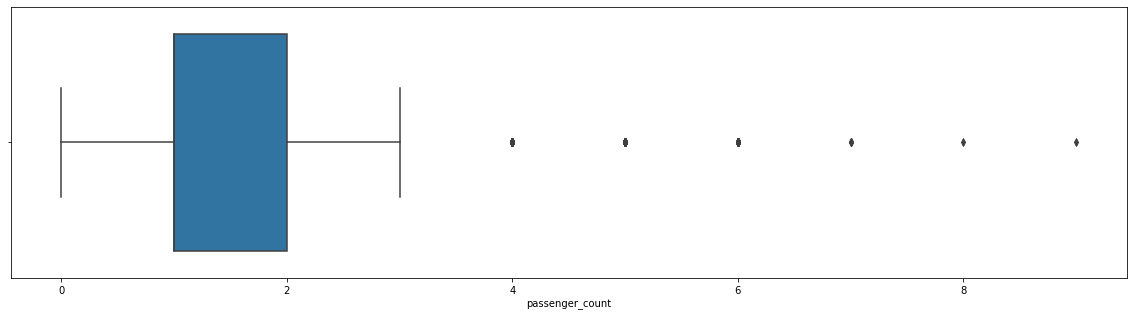

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

In [ ]:
data.passenger_count.describe()

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

In [ ]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [ ]:
data = data[data.passenger_count <= 6]

In [ ]:
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

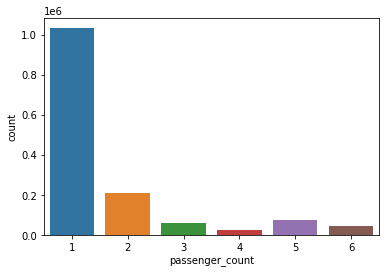

In [ ]:
sns.countplot(data.passenger_count)
plt.show()

**VENDOR**

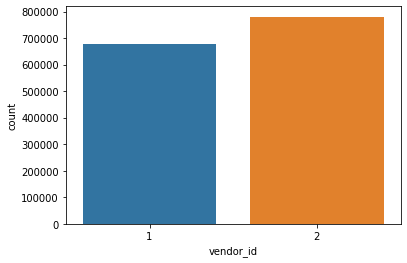

In [ ]:
sns.countplot(data.vendor_id)
plt.show()

DISTANCE

In [ ]:
print(data.distance.describe())

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


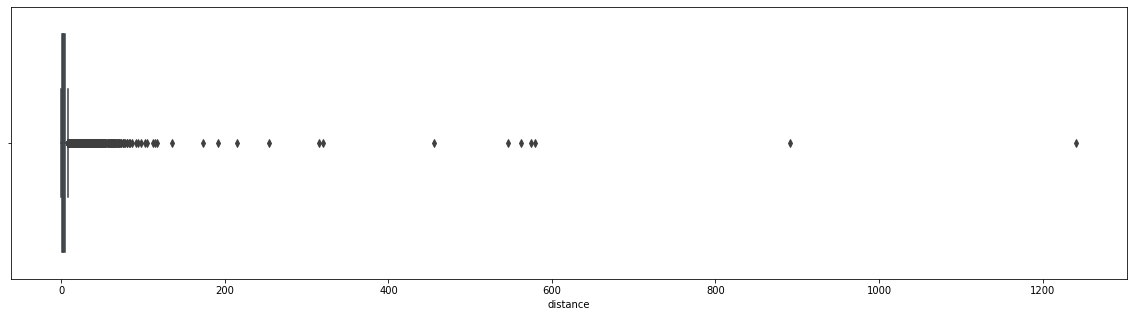

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

In [ ]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [ ]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.98,40.77,-73.98,40.77,N,...,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.96,40.78,-73.96,40.78,N,...,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.81,40.69,-73.81,40.69,N,...,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.79,40.65,-73.79,40.65,N,...,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.21,40.82,-74.21,40.82,N,...,0,1,0,0,0,0,0,0,0,0


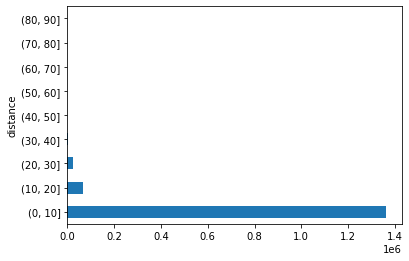

In [ ]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

TRIP DURATION


In [ ]:
data.trip_duration.describe()

count   1458639.00
mean        959.50
std        5237.44
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

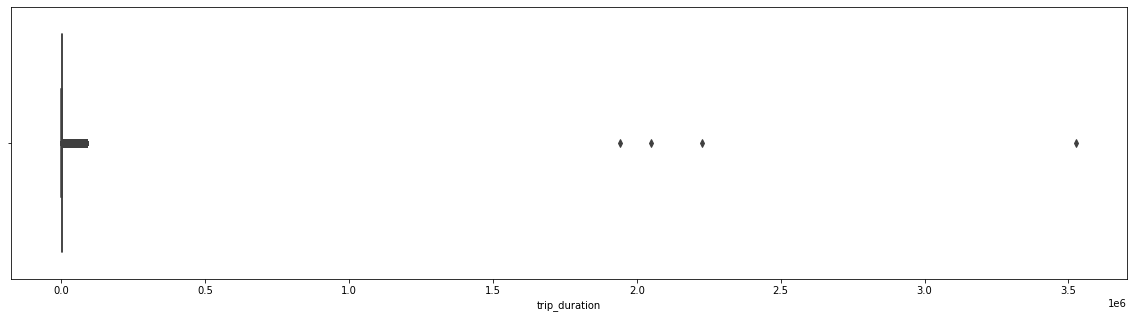

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

In [ ]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

In [ ]:
data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92,40.74,-73.98,40.76,N,...,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98,40.74,-73.99,40.73,N,...,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78,40.65,-73.98,40.75,N,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
data = data[data.trip_duration <= 86400]

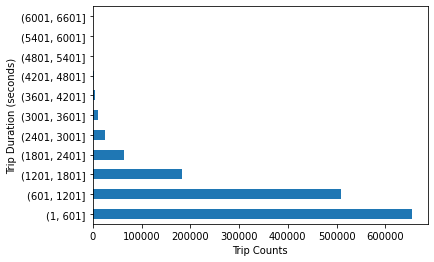

In [ ]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

SPEED

In [ ]:
data.speed.describe()

count   1458635.00
mean         14.42
std          14.98
min           0.00
25%           9.12
50%          12.79
75%          17.84
max        9274.85
Name: speed, dtype: float64

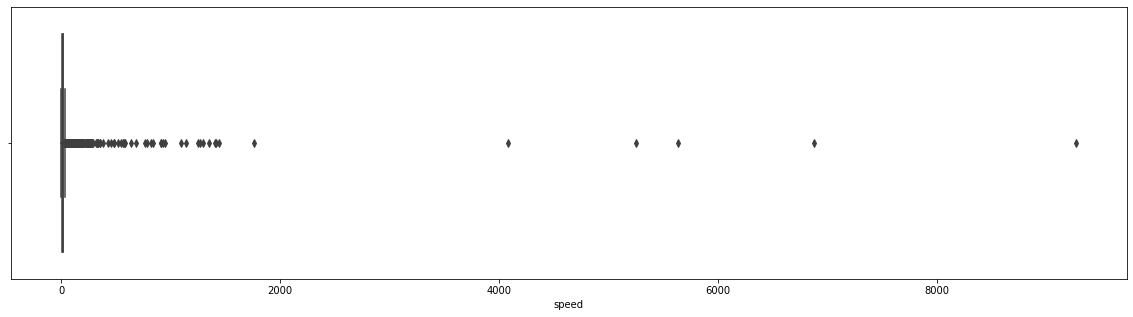

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

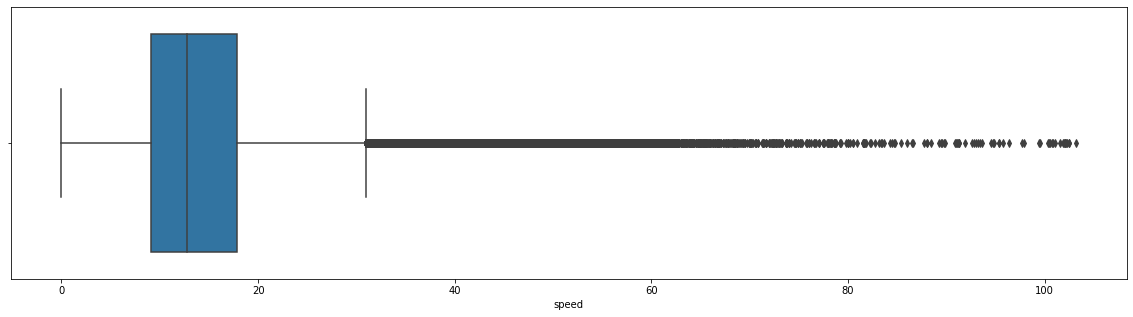

In [ ]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

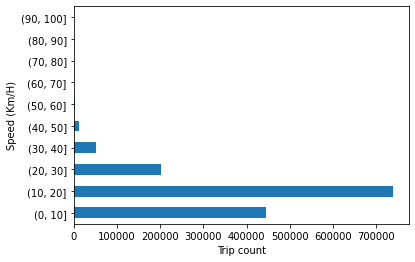

In [ ]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

STORE AND FORWARD FLAG

In [ ]:
data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

In [ ]:
data.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

In [ ]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

In [ ]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.98,40.75,-73.95,40.77,Y,...,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.98,40.76,-73.99,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
610,id0909228,1,2016-05-08 15:02:28,2016-05-08 15:17:54,1,-73.99,40.74,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0
774,id3697489,1,2016-01-13 13:53:29,2016-01-13 14:08:21,1,-73.95,40.78,-73.98,40.78,Y,...,0,1,0,0,0,0,0,0,0,0
846,id1026973,1,2016-06-25 21:53:30,2016-06-25 22:05:27,1,-73.98,40.76,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457556,id2229555,1,2016-01-22 19:05:50,2016-01-22 19:27:09,1,-73.87,40.77,-73.93,40.73,Y,...,0,1,0,0,0,0,0,0,0,0
1457670,id0510811,1,2016-04-07 21:14:30,2016-04-07 21:51:38,1,-73.78,40.64,-73.98,40.67,Y,...,0,1,0,0,0,0,0,0,0,0
1457897,id3209015,1,2016-03-20 18:49:55,2016-03-20 19:09:25,1,-73.99,40.71,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
1458060,id1371896,1,2016-03-28 11:45:49,2016-03-28 12:21:45,1,-73.97,40.76,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0


TOTAL TRIPS PER HOUR

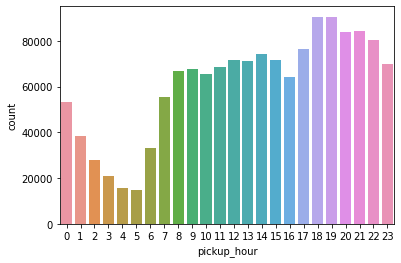

In [ ]:
sns.countplot(data.pickup_hour)
plt.show()

TOTAL TRIPS PER WEEKDAY

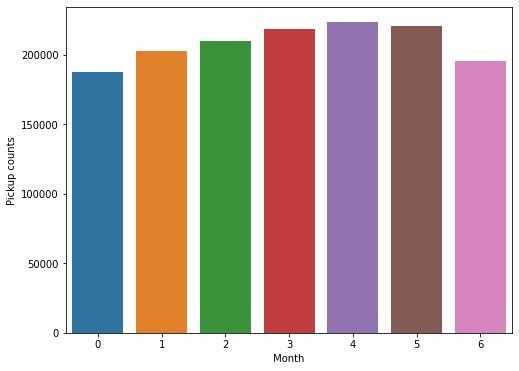

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

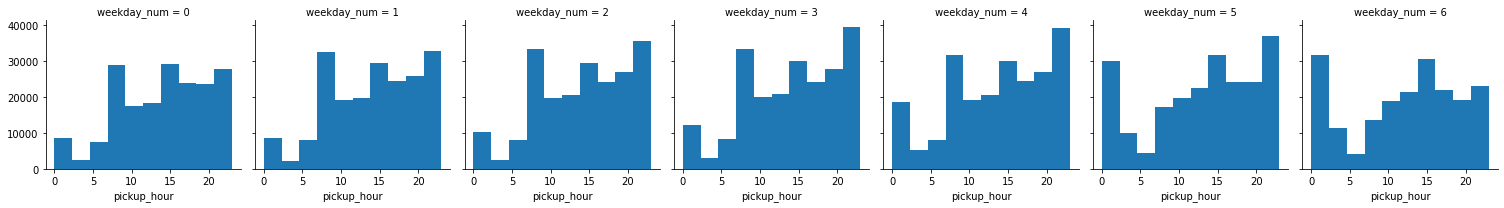

In [ ]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

TOTAL TRIPS PER MONTH

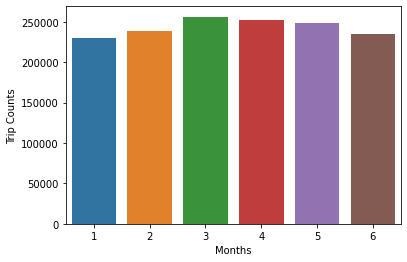

In [ ]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

BIVARIATE

TRIP DURATION PER MONTH

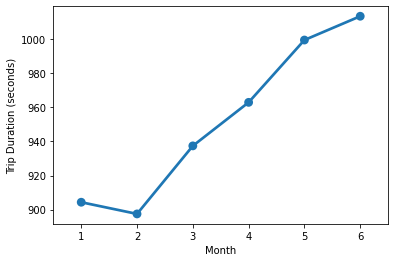

In [ ]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

TRIP DURATION PER VENDOR

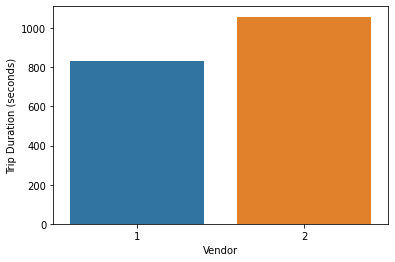

In [ ]:
group4 = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

TRIP DURATION V/S FLAG

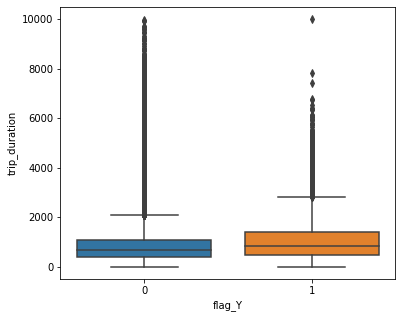

In [ ]:
plt.figure(figsize = (6,5))
plot_dur = data.loc[(data.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

DISTANCE PER MONTH

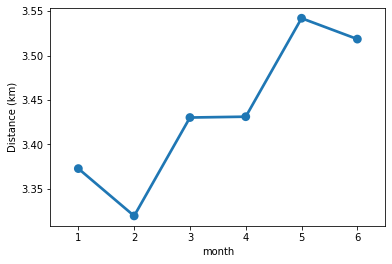

In [ ]:
group7 = data.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (km)')
plt.show()

DISTANCE PER VENDOR

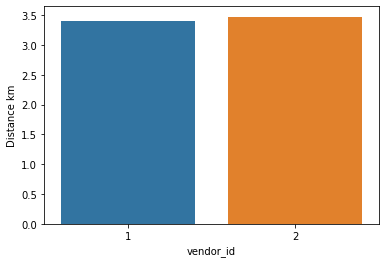

In [ ]:
group8 = data.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance km")
plt.show()

DISTANCE V/S FLAG

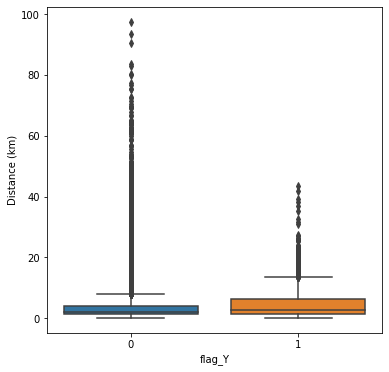

In [ ]:
plt.figure(figsize = (6,6))
plot_dist = data.loc[(data.distance < 100)]
sns.boxplot(x = "flag_Y", y = "distance", data = plot_dist)
plt.ylabel('Distance (km)')
plt.show()

DISTANCE V/S TRIP DURATION

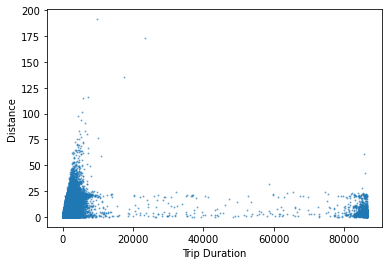

In [ ]:
plt.scatter(data.trip_duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

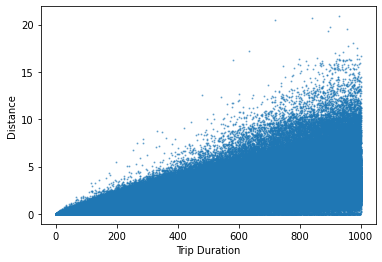

In [ ]:
dur_dist = data.loc[(data.distance < 50) & (data.trip_duration < 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

In [ ]:
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

In [ ]:
duo = data.loc[(data['distance'] <= 1) & (data['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

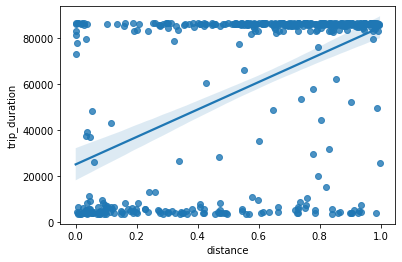

In [ ]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

In [ ]:
data = data[~((data['distance'] <= 1) & (data['trip_duration'] >= 3600))]

AVERAGE SPEED PER HOUR

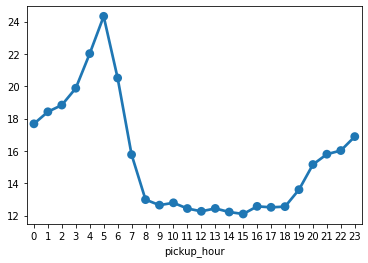

In [ ]:
group9 = data.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values)
plt.show()

AVERAGE SPEED PER WEEKDAY

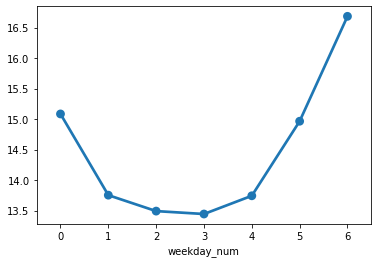

In [ ]:
group10 = data.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

PASSENGER COUNT PER VENDOR

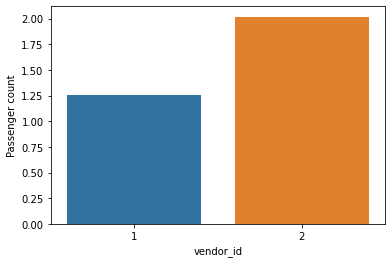

In [ ]:
group9 = data.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.show()

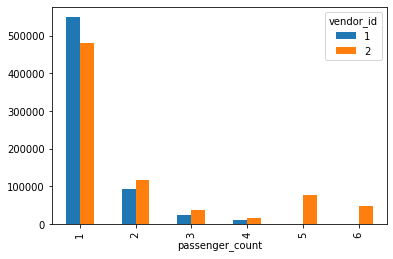

In [ ]:
data.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

FEATURE ENGINEERING 

In [ ]:
#Feature Engineering
df_train = pd.read_csv(path + 'NYC Taxi Data.csv', 
                       engine='c', 
                       infer_datetime_format=True, # to speed-up datetime parsing
                       parse_dates=[2,3] # specify datetime columns
                      )

In [ ]:
print('Memory usage, Mb: {:.2f}\n'.format(df_train.memory_usage().sum()/2**20))


Memory usage, Mb: 122.41



In [ ]:
print('DataFrame Info: ---------------------')
print(df_train.info())


DataFrame Info: ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
None


In [ ]:
df_train.store_and_fwd_flag = df_train.store_and_fwd_flag.astype('category')
# check data usage
print('Memory usage, Mb: {:.2f}\n'.format(df_train.memory_usage().sum()/2**20))

# overall df info
print('DataFrame Info: ---------------------')
print(df_train.info())

# optimize dtypes
df_train.passenger_count = df_train.passenger_count.astype(np.uint8)
df_train.vendor_id = df_train.vendor_id.astype(np.uint8)
df_train.trip_duration = df_train.trip_duration.astype(np.uint32)
for c in [c for c in df_train.columns if c.endswith('tude')]:
    df_train.loc[:, c] = df_train[c].astype(np.float32)

# now memory usage is cut by 50%
print('\nMemory usage (optimized), Mb: {:.2f}\n'.format(df_train.memory_usage().sum()/2**20))

# check sample output
df_train.head()

Memory usage, Mb: 112.68

DataFrame Info: ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  category      
 10  trip_duration       1458644 non-null  int64         
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


In [ ]:
print('No of Duplicates, Trip IDs: {}'.format(len(df_train) - 
                                              len(df_train.drop_duplicates(subset='id'))))

# check latitude/longitude bounds, Latitude: -85 to +85, Longitude: -180 to +180
print('Latitude bounds: {} to {}'.format(
    max(df_train.pickup_latitude.min(), df_train.dropoff_latitude.min()),
    max(df_train.pickup_latitude.max(), df_train.dropoff_latitude.max())
))
print('Longitude bounds: {} to {}'.format(
    max(df_train.pickup_longitude.min(), df_train.dropoff_longitude.min()),
    max(df_train.pickup_longitude.max(), df_train.dropoff_longitude.max())
))

# check trip duration - oops, looks like:
# 1) someone was on the road for 3526282sec ~ 40 days and forget to switch-off the counter, he-he
# 2) someone has invented quantum teleportation and made trips in 1-2 sec
# more closer look reveals some consecutive measurements, say, distance = 33ft, time=1sec
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()
))
# let's also check that trip_duration == drop-off time - pick-up time, nice, no errors
print("Incorrect trip duration's calculations: {}".format(
    (df_train.trip_duration != df_train.dropoff_datetime.sub(df_train.pickup_datetime, axis=0) 
     / np.timedelta64(1, 's')).sum())
)

# vendors cnt, only 2
print('Vendors cnt: {}'.format(len(df_train.vendor_id.unique())))
# datetime range - 6 full months, from January 2016 to June 2016
print('Datetime range: {} to {}'.format(df_train.pickup_datetime.min(), 
                                        df_train.dropoff_datetime.max()))

# passenger count - the common sense implies values between 1 and 10(Ford Transit), let's check
# zeroes, hmm...
print('Passengers: {} to {}'.format(df_train.passenger_count.min(), 
                                        df_train.passenger_count.max()))

No of Duplicates, Trip IDs: 0
Latitude bounds: 34.35969543457031 to 51.88108444213867
Longitude bounds: -121.93330383300781 to -61.33552932739258
Trip duration in seconds: 1 to 3526282
Incorrect trip duration's calculations: 0
Vendors cnt: 2
Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03
Passengers: 0 to 9


SOME PREPROCESSING / CLEANING

In [ ]:
# Since there are less than 10k rows with anomalies in trip_duration (in common sense), 
# we can safely remove them

duration_mask = ((df_train.trip_duration < 60) | # < 1 min
             (df_train.trip_duration > 3600*2)) # > 2 hours
print('Anomalies in trip duration, %: {:.2f}'.format(
    df_train[duration_mask].shape[0] / df_train.shape[0] * 100
))
df_train = df_train[~duration_mask]
df_train.trip_duration = df_train.trip_duration.astype(np.uint16)
# let's see range now
print('Trip duration in seconds: {} to {}'.format(
    df_train.trip_duration.min(), df_train.trip_duration.max()
))

# let's also drop trips with passenger count = 0, since there are only 17 of them
print('Empty trips: {}'.format(df_train[df_train.passenger_count == 0].shape[0]))
df_train = df_train[df_train.passenger_count > 0]

Anomalies in trip duration, %: 0.74
Trip duration in seconds: 60 to 7191
Empty trips: 17


VISUALISATION

PICK-UPS

In [ ]:
# Let's add some additional columns to speed-up calculations
# dow names for plot mapping

dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# mm names for plot mapping
mm_names = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

# month (pickup and dropoff)
df_train['mm_pickup'] = df_train.pickup_datetime.dt.month.astype(np.uint8)
df_train['mm_dropoff'] = df_train.dropoff_datetime.dt.month.astype(np.uint8)
# day of week
df_train['dow_pickup'] = df_train.pickup_datetime.dt.weekday.astype(np.uint8)
df_train['dow_dropoff'] = df_train.dropoff_datetime.dt.weekday.astype(np.uint8)
# day hour
df_train['hh_pickup'] = df_train.pickup_datetime.dt.hour.astype(np.uint8)
df_train['hh_dropoff'] = df_train.dropoff_datetime.dt.hour.astype(np.uint8)

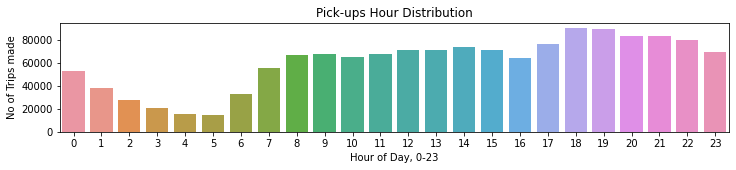

In [ ]:
#Pick up time distribution, hour-of-day

plt.figure(figsize=(12,2))

data = df_train.groupby('hh_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='hh_pickup', y='id', data=data)

plt.title('Pick-ups Hour Distribution')
plt.xlabel('Hour of Day, 0-23')
plt.ylabel('No of Trips made')
pass

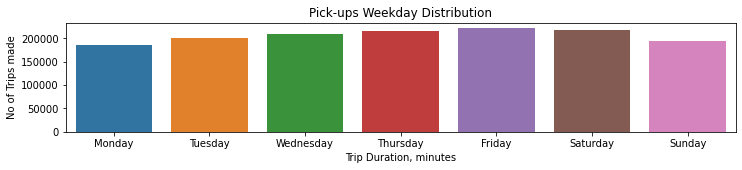

In [ ]:
#Pick up distribution, by weekday

plt.figure(figsize=(12,2))

data = df_train.groupby('dow_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='dow_pickup', y='id', data=data)

plt.title('Pick-ups Weekday Distribution')
plt.xlabel('Trip Duration, minutes')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of Trips made')
pass

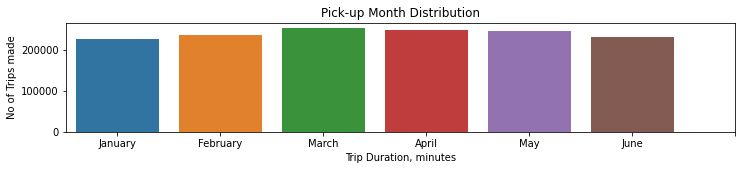

In [ ]:
#Pick up distribution, by months

plt.figure(figsize=(12,2))

data = df_train.groupby('mm_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='mm_pickup', y='id', data=data)

plt.title('Pick-up Month Distribution')
plt.xlabel('Trip Duration, minutes')
plt.xticks(range(0,7), mm_names[:6], rotation='horizontal')
plt.ylabel('No of Trips made')
pass

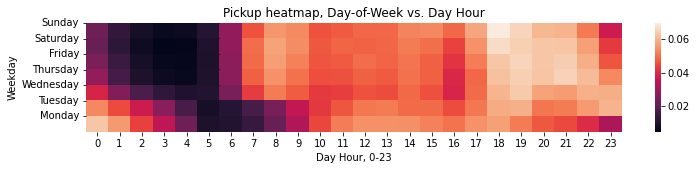

In [ ]:
#Pickup Heatmap, DOW v/s hour

plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df_train.dow_pickup, 
                             df_train.hh_pickup, 
                             values=df_train.vendor_id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')
pass

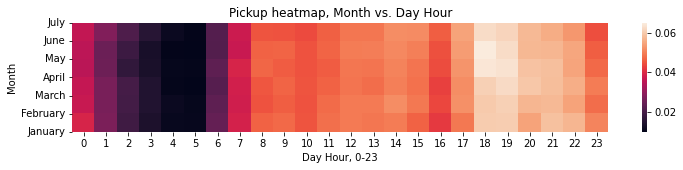

In [ ]:
#Pickup Heatmap, month v/s hour

plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df_train.mm_pickup, 
                             df_train.hh_pickup, 
                             values=df_train.vendor_id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Month vs. Day Hour')
plt.ylabel('Month') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), mm_names[:7][::-1], rotation='horizontal')
pass

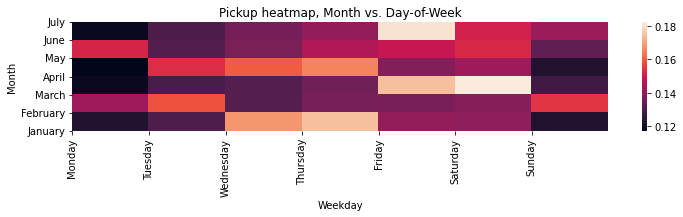

In [ ]:
#Pickup Heatmap, month v/s DOW

plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df_train.mm_pickup, 
                             df_train.dow_pickup, 
                             values=df_train.vendor_id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Month vs. Day-of-Week')
plt.ylabel('Month') ; plt.xlabel('Weekday')
plt.xticks(range(0,7), dow_names, rotation='vertical')
plt.yticks(range(0,7), mm_names[:7][::-1], rotation='horizontal')
pass

In [ ]:
#Vendor pickup hours densityby weekdays

plt.figure(figsize=(12,6))
sns.violinplot(x=df_train.dow_pickup, 
               y=df_train.hh_pickup, 
               hue=df_train.vendor_id, 
               split=True)

plt.title('Vendor pick-up hours density, by weekday')
plt.xlabel('Weekday') ; plt.ylabel('Day Hour, 0-23')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
pass

TRIP DURATION

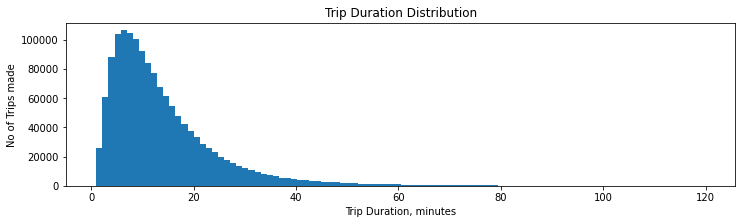

In [ ]:
#trip duration distribution, minutes
plt.figure(figsize=(12,3))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('No of Trips made')
plt.hist(df_train.trip_duration/60, bins=100)
pass

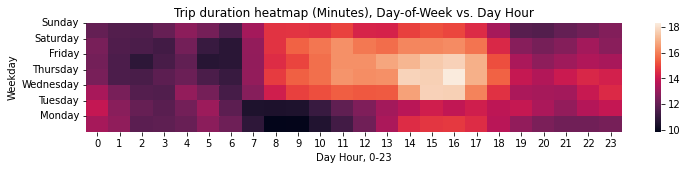

In [ ]:
# trip duration, based on hour-of-day vs. weekday
# Pickup heatmap, dow vs hour
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df_train.dow_pickup, 
                             df_train.hh_pickup, 
                             values=df_train.trip_duration/60, 
                             aggfunc='mean',
                             ))

plt.title('Trip duration heatmap (Minutes), Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')
pass

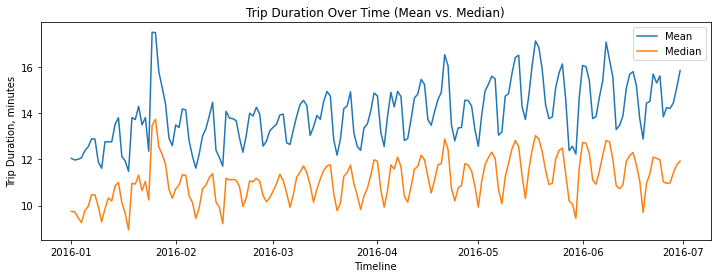

In [ ]:
# trip duration time-series by day, mean vs. median
data = df_train.groupby(df_train.pickup_datetime.dt.date).aggregate({'trip_duration':['mean', 'median']})/60
plt.figure(figsize=(12,4))
plt.title('Trip Duration Over Time (Mean vs. Median)')
plt.ylabel('Trip Duration, minutes') ; plt.xlabel('Timeline')
plt.plot(data)
plt.legend(['Mean', 'Median'])
pass

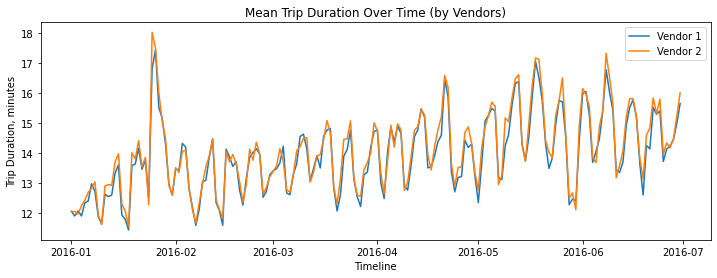

In [ ]:
# trip duration over time, vendors comparison
# seems like they are almost equal
data = pd.crosstab(index=df_train.pickup_datetime.dt.date, 
                   columns=df_train.vendor_id, 
                   values=df_train.trip_duration/60, 
                   aggfunc='mean')
plt.figure(figsize=(12,4))
plt.title('Mean Trip Duration Over Time (by Vendors)')
plt.ylabel('Trip Duration, minutes') ; plt.xlabel('Timeline')
plt.plot(data)
plt.legend(['Vendor 1', 'Vendor 2'])
pass